# NO2 and GDP Analysis

## Library

In [1]:
from pathlib import Path

import plotnine as p9
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd
import shap
import numpy as np

import warnings

warnings.filterwarnings("ignore")

PROJECT_ROOT = Path().cwd().parent.parent
DATA_PATH = PROJECT_ROOT / "data"
CROPLAND_PATH = DATA_PATH / "EVI and Crop Land" / "Crop Land"
BOUNDARIES_PATH = DATA_PATH / "Shapefiles"

## Functions

In [2]:
def clean_names(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize column names."""
    df = df.rename(columns=lambda col: col.strip().lower().replace(" ", "_"))
    return df


def format_currency_labels(label: list[float]) -> list[str]:
    """Format currency labels by shortening large numbers with K, M, B suffixes."""
    labels = []
    for v in label:
        if v >= 1_000_000_000:
            labels.append("{:.1f}B".format(v / 1_000_000_000))
        elif v >= 1_000_000:
            labels.append("{:.1f}M".format(v / 1_000_000))
        elif v >= 1_000:
            labels.append("{:.1f}K".format(v / 1_000))
        else:
            labels.append(str(v))
    return labels

## Data

This analysis utilizes the following datasets:

* Overall GDP Data: Sourced from the World Bank World Development Indicators (WDI) database
* Sectoral GDP Data: Provided by the Myanmar team
* Enhanced Vegetation Index (EVI) Data: Derived from MODIS satellite imagery

In [3]:
gdp_overall = (
    (
        pd.read_csv(DATA_PATH / "GDP" / "GDP All Countries.csv", skiprows=4)
        .pipe(clean_names)
        .loc[lambda df: df["country_name"] == "Myanmar"]
    )
    .melt(
        id_vars=["country_name", "country_code", "indicator_name", "indicator_code"],
        var_name="year",
        value_name="gdp_overall",
    )
    .dropna(subset=["gdp_overall"])
    .assign(
        date=lambda df: pd.to_datetime(df["year"], format="%Y"),
        gdp_overall=lambda df: df["gdp_overall"] / 1_000_000,
    )
    .set_index("date")
)

In [4]:
gdp_quarterly_raw = pd.read_excel(
    DATA_PATH / "GDP" / "Quarterly GDP per Sector.xlsx",
    sheet_name=1,
    skiprows=1,
    skipfooter=1,
)
gdp_adm1_raw = pd.read_excel(
    DATA_PATH / "GDP" / "Quarterly GDP per Sector.xlsx", sheet_name=0, skiprows=1
).rename(columns={"Unnamed: 0": "ADM1_NAME"})

In [5]:
ntl_adm0_raw = pd.read_csv(DATA_PATH / "NTL" / "ntl_monthly_adm0_collection2.csv").drop(
    columns=["Unnamed: 0", "Unnamed: 0.1", "geometry"]
)
ntl_adm1_raw = pd.read_csv(DATA_PATH / "NTL" / "ntl_monthly_adm1_collection2.csv").drop(
    columns=["Unnamed: 0", "Unnamed: 0.1", "geometry"]
)

ntl_adm0 = (
    ntl_adm0_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .groupby(pd.Grouper(freq="QS"))
    .agg({"ntl_mean": "mean", "ntl_sum": "sum"})
    .assign(
        ntl_sum_lag_1=lambda df: df["ntl_sum"].shift(-1),
        ntl_sum_lag_2=lambda df: df["ntl_sum"].shift(-2),
    )
)

ntl_adm1 = (
    ntl_adm1_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .rename(columns={"adm1_en": "adm1_name"})
    .groupby(["adm1_name", pd.Grouper(freq="QS")])
    .agg({"ntl_mean": "mean", "ntl_sum": "sum"})
)

In [6]:
no2_adm3_raw = pd.read_csv(DATA_PATH / "AirPollution" / "myanmar_no2_adm3.csv").rename(
    columns={"start_date": "date"}
)
no2_industrial_raw = pd.read_csv(
    DATA_PATH / "AirPollution" / "myanmar_no2_industrial_zones.csv"
)

no2_adm3 = (
    no2_adm3_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .rename(columns={"adm3_en": "adm3_name"})
    .groupby(["adm3_name", pd.Grouper(freq="QS")])
    .agg({"no2_column_number_density": "mean"})
    .rename(columns={"no2_column_number_density": "no2"})
)

no2_adm1 = (
    no2_adm3_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .rename(columns={"adm1_en": "adm1_name"})
    .groupby(["adm1_name", pd.Grouper(freq="QS")])
    .agg({"no2_column_number_density": "mean"})
    .rename(columns={"no2_column_number_density": "no2"})
)

no2_adm0 = (
    no2_adm3_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .groupby([pd.Grouper(freq="QS")])
    .agg({"no2_column_number_density": "mean"})
    .rename(columns={"no2_column_number_density": "no2"})
)

In [7]:
adm1_name_map = {
    "Ayeyarwaddy Region": "Ayeyarwady",
    "Bago Region": "Bago",
    "Chin State": "Chin",
    "Kachin State": "Kachin",
    "Kayah State": "Kayah",
    "Kayin State": "Kayin",
    "Magwe Region": "Magway",
    "Mandalay Region": "Mandalay",
    "Mon State": "Mon",
    "Nay Pyi Taw Council": "Nay Pyi Taw",
    "Rakhine State": "Rakhine",
    "Sagaing Region": "Sagaing",
    "Shan State": "Shan",
    "Tanintharyi Region": "Tanintharyi",
    "Yangon Region": "Yangon",
}


def preprocess_bago_and_shan(df: pd.DataFrame) -> pd.DataFrame:
    """Split the values of Bago into two equal parts and Shan into three equal parts."""
    df_bago = df.query("adm1_name == 'Bago'").copy()
    df_bago_new = pd.DataFrame(
        {
            "adm1_name": ["Bago (East)", "Bago (West)"],
            "industry": [df_bago["industry"].values[0] / 2] * 2,
            "services": [df_bago["services"].values[0] / 2] * 2,
        }
    )

    df_shan = df.query("adm1_name == 'Shan'").copy()
    df_shan_new = pd.DataFrame(
        {
            "adm1_name": ["Shan (South)", "Shan (East)", "Shan (North)"],
            "industry": [df_shan["industry"].values[0] / 3] * 3,
            "services": [df_shan["services"].values[0] / 3] * 3,
        }
    )

    df_rest = df.query("adm1_name not in ['Bago', 'Shan']").copy()

    return pd.concat([df_rest, df_bago_new, df_shan_new], ignore_index=True)


gdp_adm1 = (
    gdp_adm1_raw.pipe(clean_names)
    .assign(adm1_name=lambda df: df["adm1_name"].map(adm1_name_map))
    .pipe(preprocess_bago_and_shan)
    .assign(
        industry_pct=lambda df: df["industry"] / df["industry"].sum(),
        services_pct=lambda df: df["services"] / df["services"].sum(),
    )
)

gdp_quarterly = (
    gdp_quarterly_raw.pipe(clean_names)
    .melt(
        id_vars=["quarter", "sub_group", "economic_activity"],
        var_name="year",
        value_name="gdp",
    )
    .assign(
        quarter_clean=lambda df: df["quarter"].str.strip(),
        year_first=lambda df: df["year"].str.split("-").str[0].str.strip(),
        year_last=lambda df: df["year"].str.split("-").str[1].str.strip(),
        # Map fiscal quarters to calendar quarters and years
        calendar_quarter=lambda df: df["quarter_clean"].map(
            {"Q1": "Q2", "Q2": "Q3", "Q3": "Q4", "Q4": "Q1"}
        ),
        year_selected=lambda df: df.apply(
            lambda row: row["year_last"]
            if row["quarter_clean"] == "Q4"
            else row["year_first"],
            axis=1,
        ),
        # year_selected=lambda df: df.apply(
        #     lambda row: row["year_last"]
        #     if row["quarter_clean"] in ["Q1", "Q2"]
        #     else row["year_first"],
        #     axis=1,
        # ),
        date=lambda df: pd.to_datetime(df["year_selected"] + df["calendar_quarter"]),
        sub_group=lambda df: df["sub_group"].str.strip(),
        economic_activity=lambda df: df["economic_activity"].str.strip(),
    )
    .set_index("date")
    .sort_index()
    .groupby(["sub_group", "economic_activity", pd.Grouper(freq="QS")])
    .agg({"gdp": "sum"})
    .reset_index()
    .sort_values(["sub_group", "economic_activity", "date"])
    .groupby(["sub_group", "economic_activity"])
    .apply(
        lambda df: df.assign(
            gdp_lag_1=df["gdp"].shift(1),
            gdp_lag_2=df["gdp"].shift(2),
            gdp_log=np.log(df["gdp"]),
        )
    )
    .reset_index(drop=True)
    .query('sub_group != "Agriculture"')
)

gdp_quarterly_adm1 = (
    pd.DataFrame(
        [
            (region, period)
            for region in gdp_adm1["adm1_name"].unique()
            for period in gdp_quarterly["date"].unique()
        ],
        columns=["adm1_name", "date"],
    )
    .merge(
        gdp_adm1.filter(["adm1_name", "industry_pct", "services_pct"]),
        on="adm1_name",
        how="left",
    )
    .merge(gdp_quarterly, on="date", how="left")
    .rename(
        columns={
            "gdp": "gdp_total",
            "gdp_lag_1": "gdp_total_lag_1",
            "gdp_lag_2": "gdp_total_lag_2",
            "gdp_log": "gdp_total_log",
        }
    )
    .assign(
        gdp=lambda df: df.apply(
            lambda row: row["gdp_total"] * row["industry_pct"]
            if row["sub_group"] == "Industry"
            else row["gdp_total"] * row["services_pct"],
            axis=1,
        ),
        gdp_lag_1=lambda df: df.apply(
            lambda row: row["gdp_total_lag_1"] * row["industry_pct"]
            if row["sub_group"] == "Industry"
            else row["gdp_total_lag_1"] * row["services_pct"],
            axis=1,
        ),
        gdp_lag_2=lambda df: df.apply(
            lambda row: row["gdp_total_lag_2"] * row["industry_pct"]
            if row["sub_group"] == "Industry"
            else row["gdp_total_lag_2"] * row["services_pct"],
            axis=1,
        ),
        gdp_log=lambda df: np.log(df["gdp"]),
    )
)

## NO2

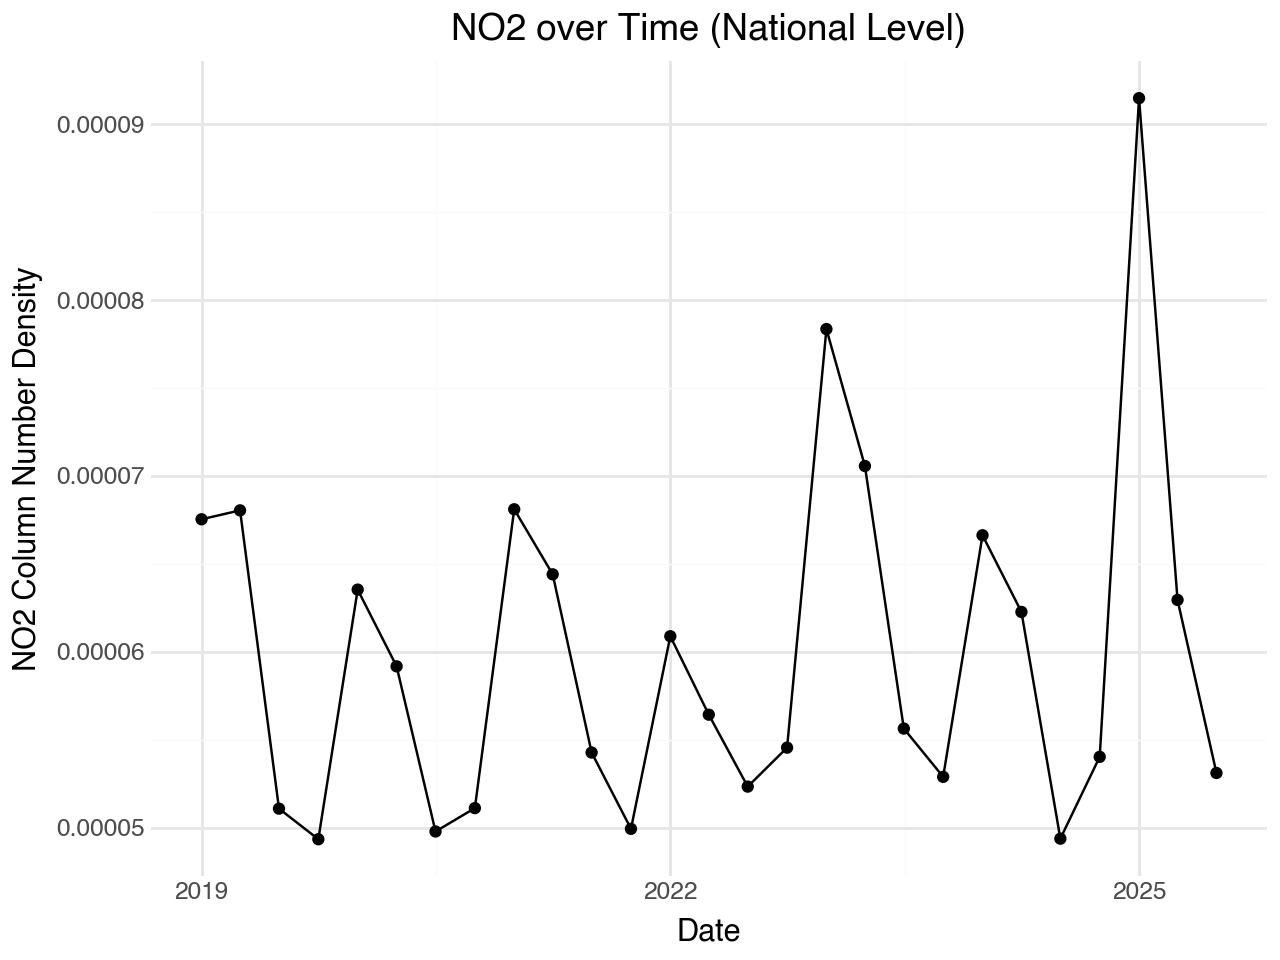

In [8]:
(
    no2_adm0.reset_index().pipe((p9.ggplot, "data"))
    + p9.aes(x="date", y="no2")
    + p9.geom_point()
    + p9.geom_line()
    + p9.scale_x_datetime(date_labels="%Y", date_breaks="3 year")
    + p9.labs(
        title="NO2 over Time (National Level)",
        x="Date",
        y="NO2 Column Number Density",
    )
    + p9.theme_minimal()
)

### Admin Level 0

In [9]:
# selected_regions = ["Yangon", "Mandalay", "Sagaing"]
selected_regions = ["Yangon"]

selected_activities = [
    "Construction",
    "Manufacturing",
    "Mining",
    "Trade",
    "Transportation",
    "Electricity",
    "Energy",
]

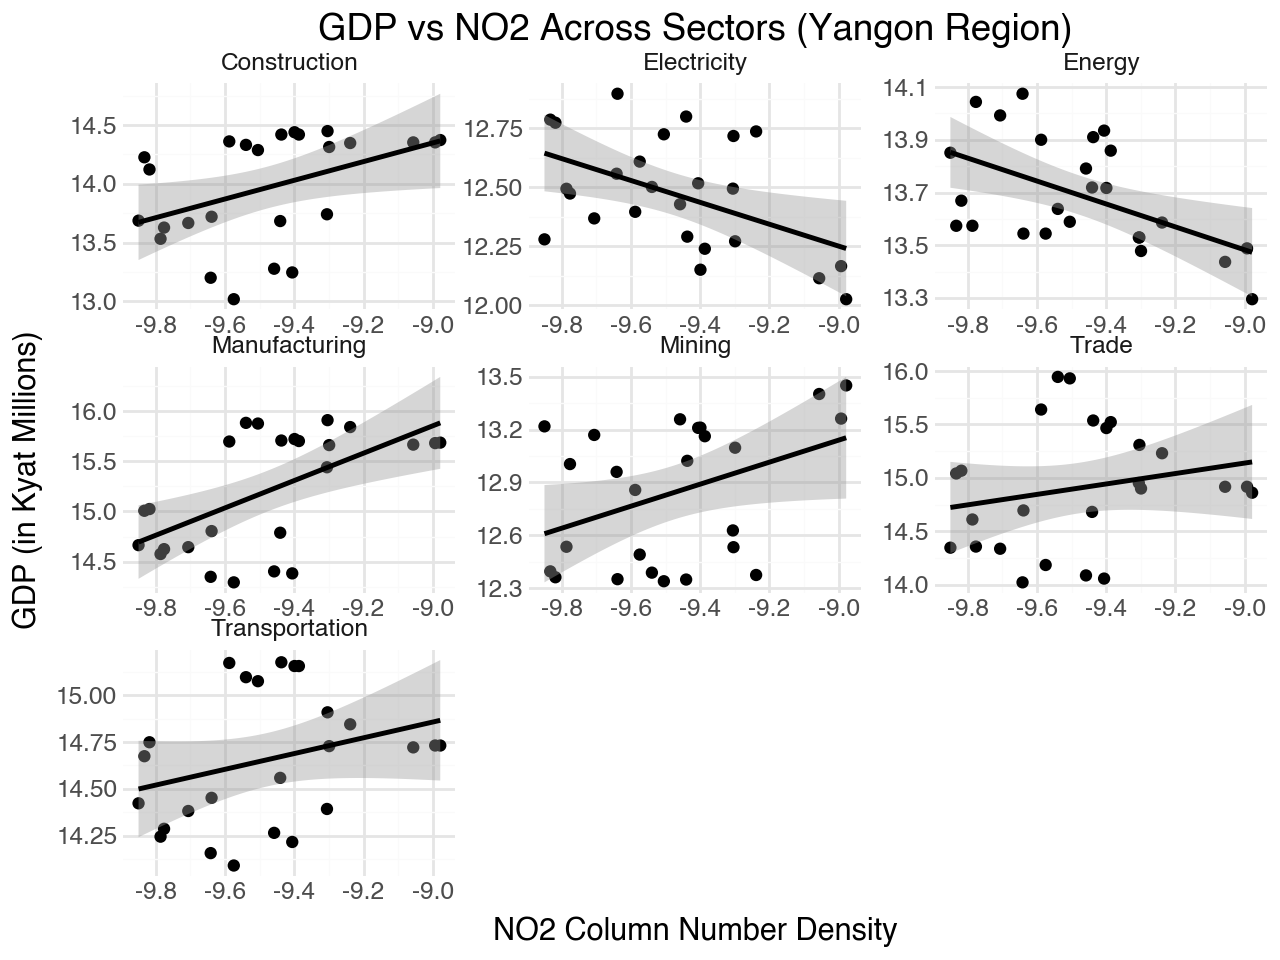

In [10]:
no2_adm0_subset = (
    no2_adm1.reset_index()
    .query("adm1_name in @selected_regions")
    .groupby("date")
    .agg({"no2": "mean"})
    .reset_index()
    .assign(
        no2_lag_1=lambda df: df["no2"].shift(1),
        no2_lag_2=lambda df: df["no2"].shift(2),
        no2_log=lambda df: np.log(df["no2"]),
        no2_lag_1_log=lambda df: np.log(df["no2_lag_1"]),
        no2_lag_2_log=lambda df: np.log(df["no2_lag_2"]),
    )
)

no2_indicators = (
    gdp_quarterly.reset_index()
    # Subset to selected regions
    .merge(no2_adm0_subset, on="date", how="inner")
    .merge(ntl_adm0.reset_index(), on="date", how="left")
    .assign(
        ntl_sum_log=lambda df: np.log(df["ntl_sum"]),
        ntl_sum_lag_1=lambda df: df["ntl_sum"].shift(1),
        ntl_sum_lag_1_log=lambda df: np.log(df["ntl_sum_lag_1"]),
    )
)

(
    no2_indicators.query("economic_activity in @selected_activities").pipe(
        (p9.ggplot, "data")
    )
    + p9.aes(x="no2_log", y="gdp_log")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.facet_wrap("economic_activity", scales="free", ncol=3)
    + p9.labs(
        title="GDP vs NO2 Across Sectors (Yangon Region)",
        x="NO2 Column Number Density",
        y="GDP (in Kyat Millions)",
    )
    + p9.theme_minimal()
)

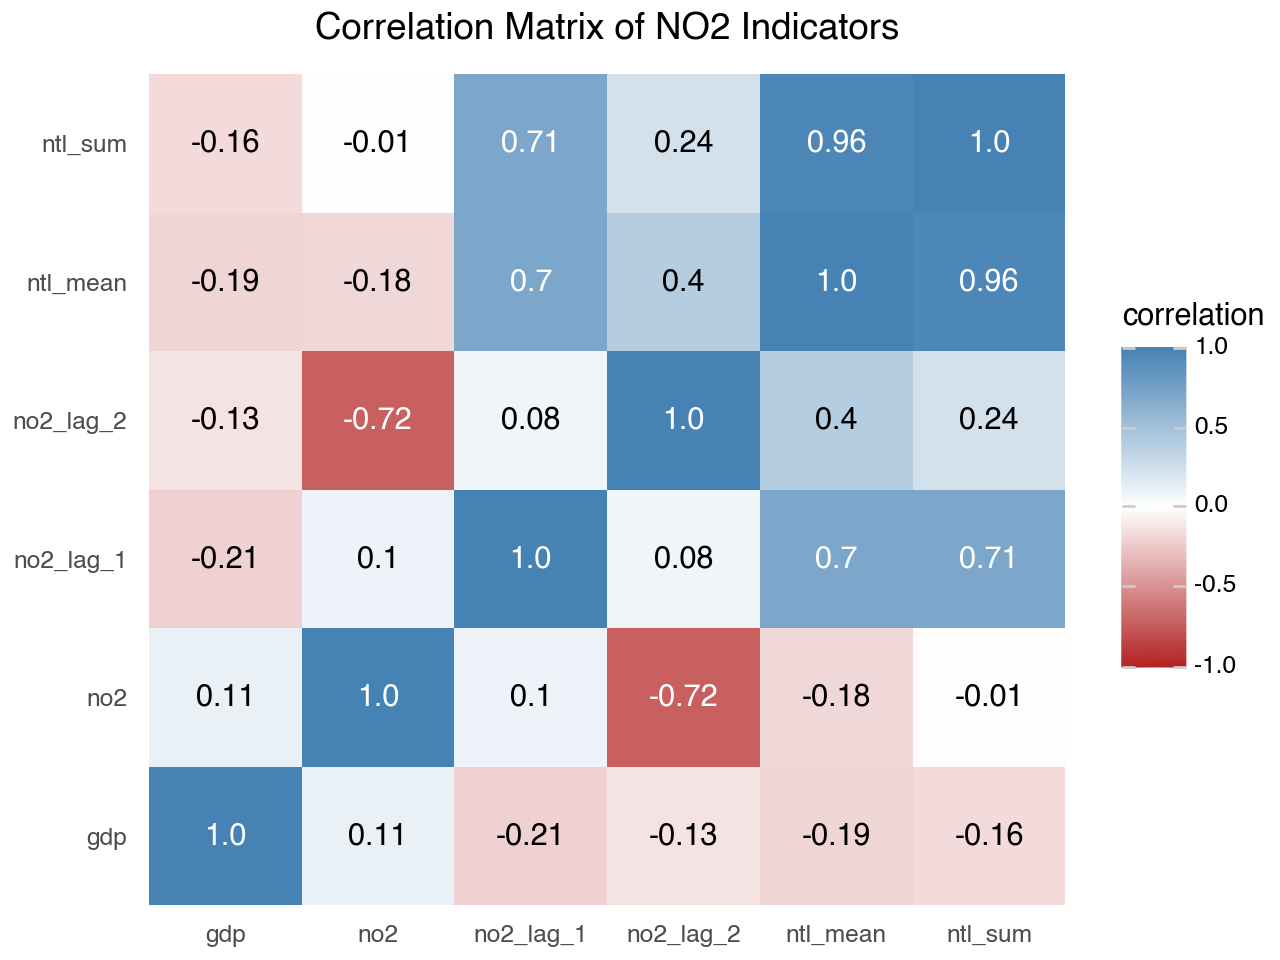

In [11]:
(
    no2_indicators.filter(
        [
            "gdp",
            "no2",
            "no2_lag_1",
            "no2_lag_2",
            "ntl_mean",
            "ntl_sum",
        ]
    )
    .corr()
    .reset_index()
    .melt(id_vars=["index"], var_name="variable", value_name="correlation")
    .rename(columns={"index": "variable_1", "variable": "variable_2"})
    .assign(
        correlation=lambda df: df["correlation"].round(2),
        text_color=lambda df: df["correlation"].apply(
            lambda x: "white" if abs(x) > 0.5 else "black"
        ),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="variable_1", y="variable_2", fill="correlation")
    + p9.geom_tile()
    + p9.scale_fill_gradient2(
        low="firebrick", mid="white", high="steelblue", limits=(-1, 1)
    )
    + p9.geom_text(p9.aes(label="correlation", color="text_color"))
    + p9.scale_color_identity()
    + p9.labs(title="Correlation Matrix of NO2 Indicators", x="", y="")
    + p9.theme_minimal()
    + p9.theme(panel_grid_major=p9.element_blank())
)

In [12]:
mod_1 = smf.ols("gdp_log ~ no2_log", data=no2_indicators).fit()
mod_2 = smf.ols("gdp_log ~ ntl_sum_log + no2_log", data=no2_indicators).fit()
mod_3 = smf.ols(
    "gdp_log ~ ntl_sum_log + no2_log + no2_lag_1_log", data=no2_indicators
).fit()

Stargazer([mod_1, mod_2, mod_3])

In [13]:
mod_4 = smf.ols(
    "gdp_log ~ ntl_sum_log + no2_log + no2_lag_1_log + C(economic_activity, Treatment('Manufacturing'))",
    data=no2_indicators,
).fit()

Stargazer([mod_4])

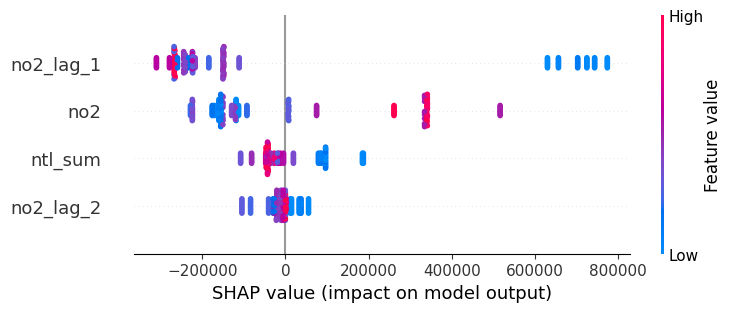

In [14]:
no2_indicators_clean = no2_indicators.dropna()
X = no2_indicators_clean[["no2", "ntl_sum", "no2_lag_1", "no2_lag_2"]]
y = no2_indicators_clean["gdp"]

model = GradientBoostingRegressor()
model.fit(X, y)

explainer_xgb = shap.Explainer(model)
shap_values = explainer_xgb(X)

shap.plots.beeswarm(shap_values)

In [15]:
no2_adm1_subset = no2_adm1.reset_index().query("adm1_name in @selected_regions")

no2_indicators_adm1 = (
    gdp_quarterly_adm1.merge(
        no2_adm1_subset.reset_index(), on=["adm1_name", "date"], how="left"
    )
    .merge(ntl_adm1.reset_index(), on=["adm1_name", "date"], how="left")
    .sort_values(["adm1_name", "date"])
    .groupby(["adm1_name", "sub_group", "economic_activity"])
    .apply(
        lambda df: df.assign(
            no2_log=lambda df: np.log(df["no2"]),
            no2_lag_1=df["no2"].shift(1),
            no2_lag_2=df["no2"].shift(2),
            no2_lag_1_log=lambda df: np.log(df["no2_lag_1"]),
            no2_lag_2_log=lambda df: np.log(df["no2_lag_2"]),
            ntl_sum_log=lambda df: np.log(df["ntl_sum"]),
            ntl_sum_lag_1=df["ntl_sum"].shift(1),
            ntl_sum_lag_1_log=lambda df: np.log(df["ntl_sum_lag_1"]),
        ),
    )
    .reset_index(drop=True)
)

no2_indicators_adm1

,adm1_name,date,industry_pct,services_pct,sub_group,economic_activity,gdp_total,gdp_total_lag_1,gdp_total_lag_2,gdp_total_log,...,ntl_mean,ntl_sum,no2_log,no2_lag_1,no2_lag_2,no2_lag_1_log,no2_lag_2_log,ntl_sum_log,ntl_sum_lag_1,ntl_sum_lag_1_log
0,Ayeyarwady,2010-04-01,0.050698,0.100629,Industry,Construction,3.078736e+05,NaN,NaN,12.637445,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Ayeyarwady,2010-07-01,0.050698,0.100629,Industry,Construction,5.358950e+05,3.078736e+05,NaN,13.191693,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Ayeyarwady,2010-10-01,0.050698,0.100629,Industry,Construction,8.885242e+05,5.358950e+05,3.078736e+05,13.697317,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Ayeyarwady,2011-01-01,0.050698,0.100629,Industry,Construction,6.357352e+05,8.885242e+05,5.358950e+05,13.362537,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ayeyarwady,2011-04-01,0.050698,0.100629,Industry,Construction,3.466192e+05,6.357352e+05,8.885242e+05,12.755982,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11875,Yangon,2024-01-01,0.353952,0.284509,Services,Transportation,2.475646e+06,3.826764e+06,1.760905e+06,14.722012,...,1.288833,248295.662349,-9.056514,0.000084,0.000061,-9.386707,-9.706099,12.422376,193872.643026,12.174957
11876,Yangon,2024-04-01,0.353952,0.284509,Services,Transportation,1.566391e+06,2.475646e+06,3.826764e+06,14.264285,...,1.451145,178197.192109,-9.458223,0.000117,0.000084,-9.056514,-9.386707,12.090646,248295.662349,12.422376
11877,Yangon,2024-07-01,0.353952,0.284509,Services,Transportation,1.834863e+06,1.566391e+06,2.475646e+06,14.422480,...,1.254324,155936.478288,-9.849697,0.000078,0.000117,-9.458223,-9.056514,11.957204,178197.192109,12.090646
11878,Yangon,2024-10-01,0.353952,0.284509,Services,Transportation,3.826764e+06,1.834863e+06,1.566391e+06,15.157530,...,1.215892,175752.381717,-9.399336,0.000053,0.000078,-9.849697,-9.458223,12.076831,155936.478288,11.957204


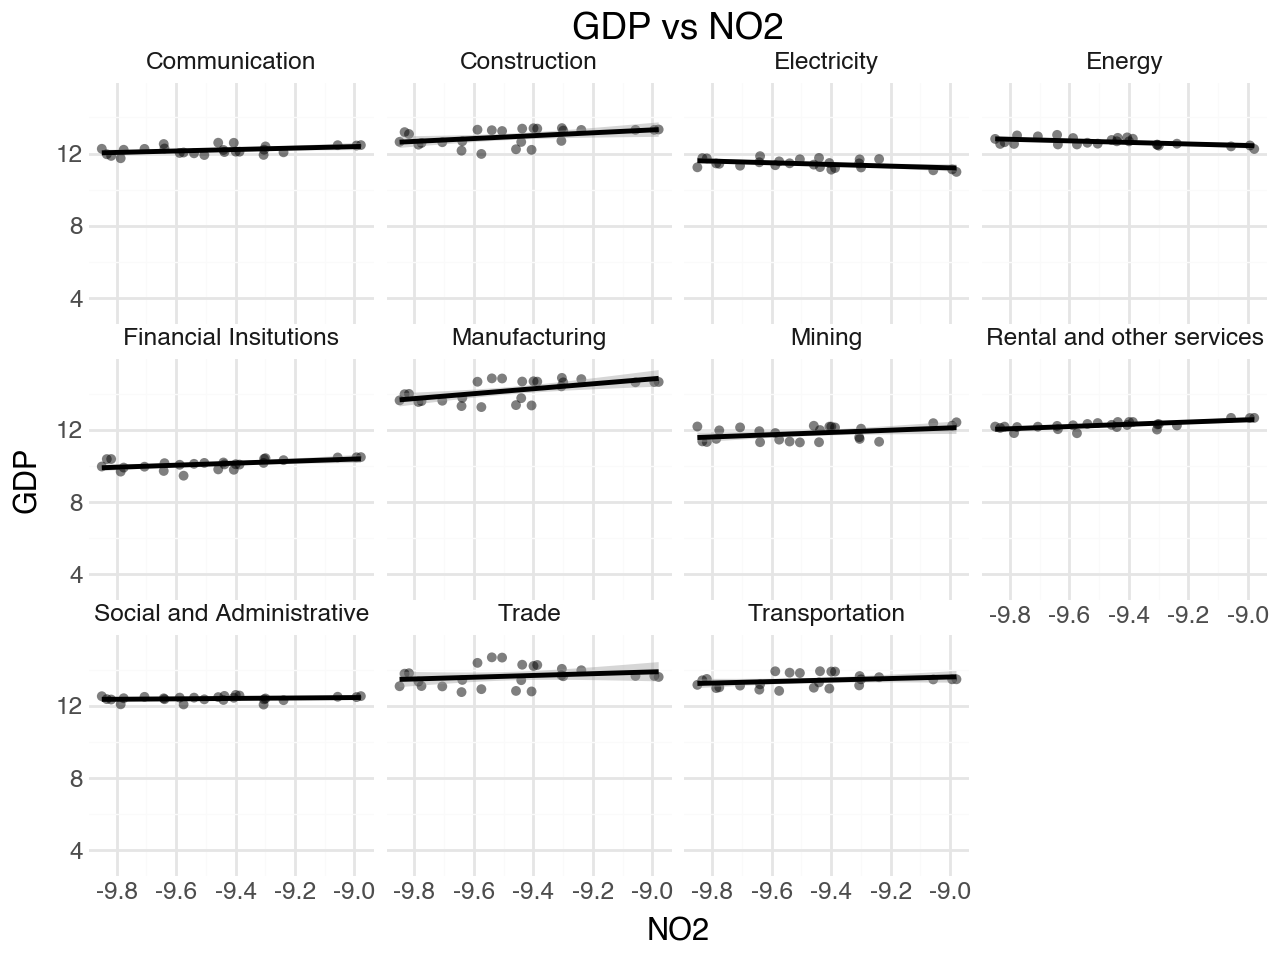

In [16]:
(
    no2_indicators_adm1.pipe((p9.ggplot, "data"))
    + p9.aes(x="no2_log", y="gdp_log")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm")
    + p9.facet_wrap("economic_activity", ncol=4)
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP vs NO2",
        x="NO2",
        y="GDP",
    )
    + p9.theme_minimal()
)

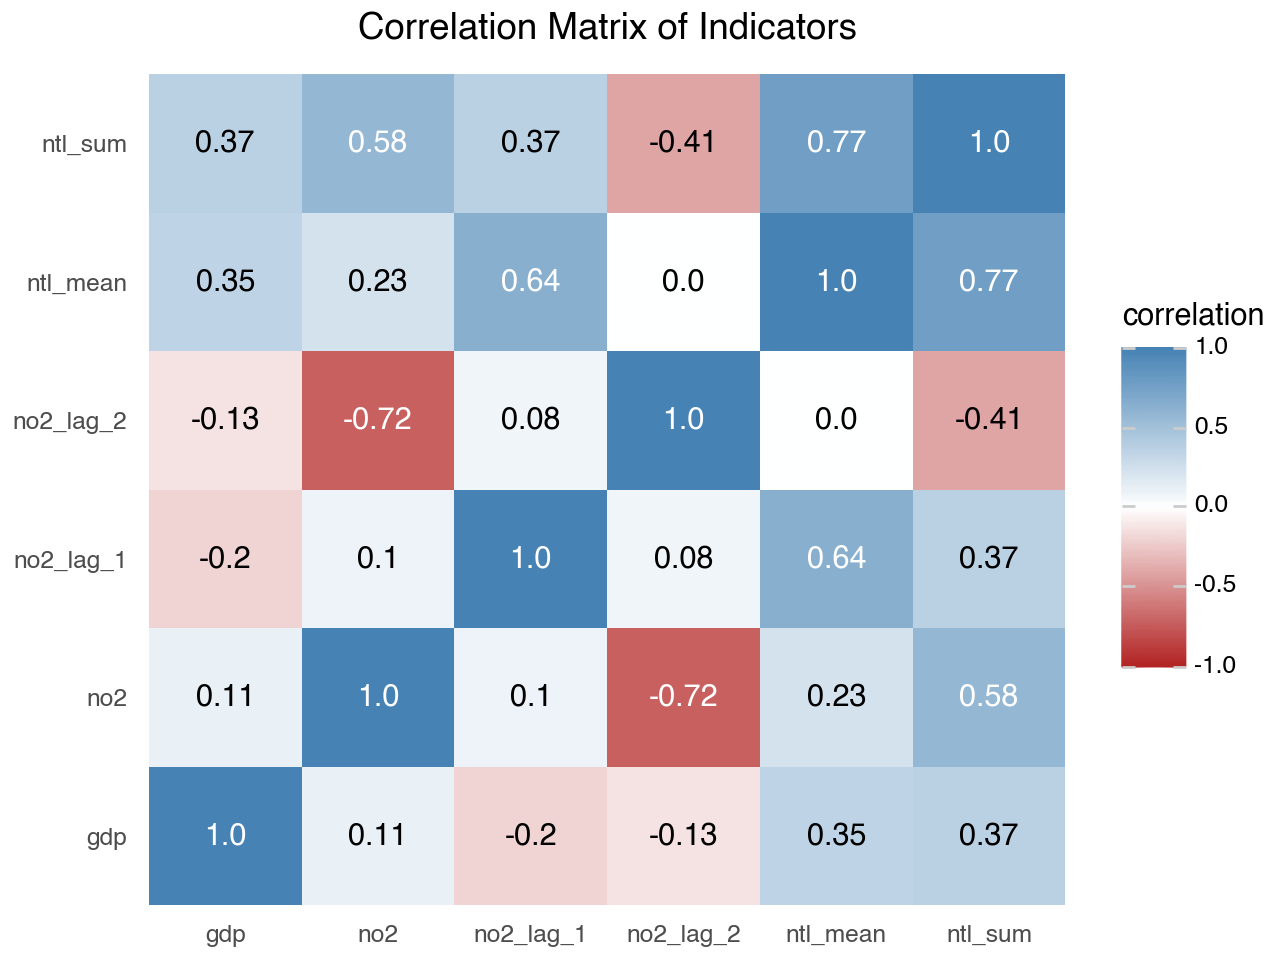

In [17]:
(
    no2_indicators_adm1.filter(
        [
            "gdp",
            "no2",
            "no2_lag_1",
            "no2_lag_2",
            "ntl_mean",
            "ntl_sum",
        ]
    )
    .corr()
    .reset_index()
    .melt(id_vars=["index"], var_name="variable", value_name="correlation")
    .rename(columns={"index": "variable_1", "variable": "variable_2"})
    .assign(
        correlation=lambda df: df["correlation"].round(2),
        text_color=lambda df: df["correlation"].apply(
            lambda x: "white" if abs(x) > 0.5 else "black"
        ),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="variable_1", y="variable_2", fill="correlation")
    + p9.geom_tile()
    + p9.scale_fill_gradient2(
        low="firebrick", mid="white", high="steelblue", limits=(-1, 1)
    )
    + p9.geom_text(p9.aes(label="correlation", color="text_color"))
    + p9.scale_color_identity()
    + p9.labs(title="Correlation Matrix of Indicators", x="", y="")
    + p9.theme_minimal()
    + p9.theme(panel_grid_major=p9.element_blank())
)

In [18]:
mod_1 = smf.ols("gdp_log ~ no2_log", data=no2_indicators_adm1).fit()
mod_2 = smf.ols("gdp_log ~ ntl_sum_log + no2_log", data=no2_indicators_adm1).fit()
mod_3 = smf.ols(
    "gdp_log ~ ntl_sum_log + no2_log + no2_lag_1_log", data=no2_indicators_adm1
).fit()

Stargazer([mod_1, mod_2, mod_3])

In [19]:
mod_4 = smf.ols(
    "gdp_log ~ ntl_sum_log + no2_log + no2_lag_1_log + C(economic_activity, Treatment('Manufacturing'))",
    data=no2_indicators_adm1,
).fit()

Stargazer([mod_4])

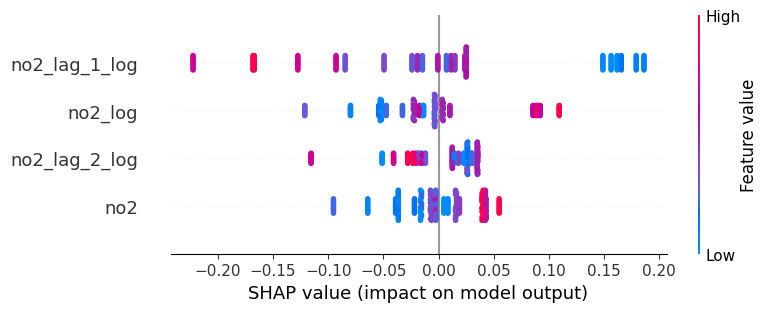

In [20]:
no2_indicators_adm_1_clean = no2_indicators_adm1.dropna()
X = no2_indicators_adm_1_clean[["no2", "no2_log", "no2_lag_1_log", "no2_lag_2_log"]]
y = no2_indicators_adm_1_clean["gdp_log"]

model = GradientBoostingRegressor()
model.fit(X, y)

explainer_xgb = shap.Explainer(model)
shap_values = explainer_xgb(X)

shap.plots.beeswarm(shap_values)